In [1]:
%matplotlib inline
%timeit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import time
import pickle
import datetime
import re
import pyActigraphy
from adjustText import adjust_text
from scipy.stats import chi2_contingency
from scipy.stats import kruskal

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import utils as wearutils
from wearables.scripts import data_v42 as weardata
from wearables.scripts import train as weartrain
from wearables.scripts import eval_v42 as weareval
from wearables.scripts import model as wearmodels
from wearables.scripts import DTW as weardtw

import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy.spatial.distance import pdist, squareform
import fastdtw
import umap

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=1
plt.rcParams['savefig.dpi'] = 600
sns.set_style("ticks")

In [2]:
def out2md_embeds(md, bst_trainerfp, bst_modelfp, embeds_out=None, out_file=None, verbose=False):
    def loadpkl(file):
        with open(file, 'rb') as f:
            data = pickle.load(f)
            f.close()
        return data
    trainer = loadpkl(bst_trainerfp)
    if verbose:
        total_t = time.time()
    dt = pd.DataFrame()
    embeds = pd.DataFrame()
    for split in ['train', 'test']: # omit val since test_pids contain val_pids (val is a subset of test)
        if verbose:
            tic = time.time()
            print('Starting inference for {} set...'.format(split))

        evaluation = weareval.eval_trained(trainer, split=split,
                                           modelpkl=bst_modelfp,
                                           two_outputs=True)
        dt = dt.append(pd.DataFrame({
            'y':evaluation.y.numpy(), 'yhat':evaluation.yhat.numpy(), 
            'split':[split]*evaluation.y.shape[0],
            'error':(evaluation.yhat - evaluation.y).numpy()
        }, index=evaluation.id))
        embeds = embeds.append(pd.DataFrame(evaluation.out2.numpy(), index=evaluation.id))
        if verbose:
            print('  inference for {} set done in {:.0f}-s\t{:.2f}-min elapsed'.format(split, time.time()-tic, (time.time()-total_t)/60))
    md = md.merge(dt, left_index=True, right_index=True, how='left')
    if out_file is not None:
        md.to_csv(out_file)
    if embeds_out is not None:
        embeds.to_csv(embeds_out)
    return md, embeds


def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)

In [3]:
# load data

pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_modelembeds = os.path.join(pfp, 'embeds_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)
trainer = loadpkl(bst_trainer)

it = pd.read_csv(bst_modelembeds, index_col=0)

# model_fp = '/home/ngrav/scratch/wearables_model_zoo'

# trainer_fp = os.path.join(model_fp, 'trainer_itrandaug_GA4.pkl')
# modelpkl = os.path.join(model_fp, '752-itrandaug_GA4.pkl')

# if not os.path.exists(trainer_fp) and os.path.exists(modelpkl):
#     print('no pickles found along that path')

In [6]:
# gen random output and save
if True:
    rand_trainerfp = os.path.join(mfp, 'trainer_itrandv52_InceptionTime_GA5.pkl')
    rand_modelfp = os.path.join(mfp, '219-itrandv52_InceptionTime_GA5.pkl')
    mdrand, itrand = out2md_embeds(md, rand_trainerfp, rand_modelfp, 
                                   embeds_out=os.path.join(pfp, 'itrand_embds.csv'), 
                                   out_file=os.path.join(pfp, 'mdrand.csv'))

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/modules/conv.py:294: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/Convolution.cpp:660.)
  return F.conv1d(input, weight, bias, self.stride,
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


In [7]:
itrand.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
1052_17,1.771701,1.428243,0.597735,1.842776,1.789717,0.067041,0.985661,0.138628,0.966715,0.080255,...,0.538040,1.485840,0.257096,0.231629,0.670199,0.478194,0.264798,1.975877,0.810702,1.989732
1022_28,2.048649,1.660239,0.440973,2.127325,2.064642,0.000000,1.075878,0.058181,1.071707,0.000000,...,0.331926,1.706971,0.113472,0.107141,0.469981,0.300796,0.323596,2.203680,0.565549,2.211856
2074_8,1.034532,0.840837,0.997630,1.083231,1.047131,0.415660,0.797919,0.416982,0.789787,0.511873,...,0.954841,0.879951,0.535052,0.464584,1.040336,0.786122,0.187312,1.141755,1.120334,1.162725
1213_29,1.720062,1.393658,0.592349,1.791802,1.736555,0.117843,1.039529,0.143921,1.026168,0.136078,...,0.519234,1.447481,0.238128,0.206179,0.641164,0.447684,0.287590,1.882428,0.750226,1.902080
1350_15,0.703034,0.570435,1.155232,0.742183,0.715725,0.538776,0.762828,0.511245,0.743226,0.657822,...,1.141908,0.614003,0.660783,0.565634,1.209489,0.934834,0.147509,0.815830,1.305026,0.840675


# unsupervised

## fastdtw graph

1. D --> annoy --> clustering (unsupervised), then association with metadata
2. self-supervised embedding (~512dimensions) --> annoy based on D with various distance metrics OR DL based clustering, then association with metadata vs. GA association with metadata (otherwise, what is novel about the groups... do subclusters identify new interesting patients?)
3. 

In [8]:
# load previous
load = True

if load:
    # load it 
    with open('/home/ngrav/scratch/data_dtw.pkl', 'rb') as f:
        data_dtw = pickle.load(f)
        f.close()
else:
    # run it
    data_dtw = weardtw.rawdata_umap_dtw(trainer_fp) #

    # since this takes so long, save it
    with open('/home/ngrav/scratch/data_dtw.pkl', 'wb') as f:
        pickle.dump(data_dtw, f, protocol=pickle.HIGHEST_PROTOCOL)
        f.close()

In [9]:
# rerun umap, forgot to return data
data_dtw['data_umap'] = weardtw.embed(data_dtw['D'])

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/umap/umap_.py:1735: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


In [10]:
dtwumap = data_dtw['data_umap']
mddtw = data_dtw['md']

In [11]:
mddtw = mddtw.merge(md.loc[:, [col for col in md.columns if col not in mddtw.columns]], left_index=True, right_index=True, how='left')

In [12]:
# # add model output 
# md = md.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md['AbsErr'] = np.abs(md['GA'] - md['actigraphy-GA'])
# md['actigraphyGA-GA'] = md['actigraphy-GA'] - md['GA']

In [13]:
savefigs = True

In [14]:
D = data_dtw['D']
membership = weardtw.leiden_clustering(D, gamma=0.5)
mddtw['leiden'] = membership

# bst model

### compare to model embeddings

can always improve upon, extract embedding output, and merge with metadata for viz

**NOTE**: need to optimize the metric selected (after pipeline for cluster annotation)

In [88]:
# md_model = md_model.loc[evaluation.id, :] # re-order to match output
# md_model = md_model.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md_model['AbsErr'] = np.abs(md_model['GA'] - md_model['actigraphy-GA'])
# md_model['actigraphyGA-GA'] = md_model['actigraphy-GA'] - md_model['GA'] 

In [89]:
itumap = weardtw.embed(it.to_numpy(), metric='manhattan')

In [90]:
from scipy.spatial.distance import pdist, squareform
D_model = squareform(pdist(it.to_numpy(), metric='cityblock'))
membership_model = weardtw.leiden_clustering(D_model, gamma=0.5)


In [91]:
# add clusters to md
md.loc[it.index, 'model_leiden'] = membership_model

In [92]:
idxs = {i:idx for i, idx in enumerate(it.index) if idx in md.loc[md['split']=='train'].index.to_list()}
xy = itumap[list(idxs.keys()), :]
dt = md.loc[list(idxs.values())]

In [93]:
it_umap = itumap[list(idxs.keys()), :]
it_md = md.loc[list(idxs.values()), :]

In [68]:
savefigs = False

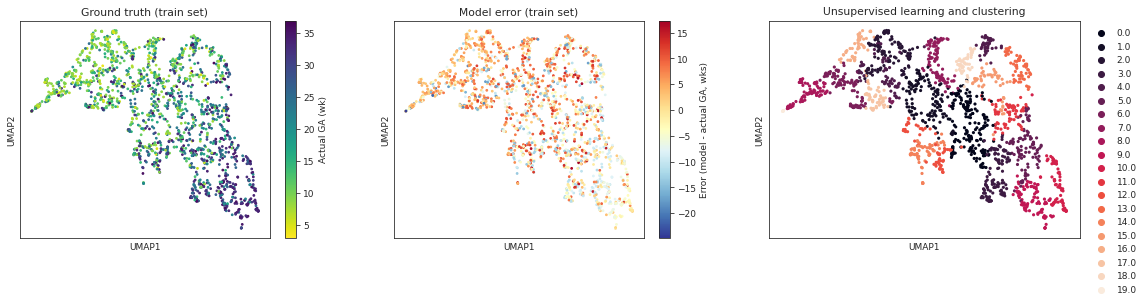

In [69]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(itumap[list(idxs.keys()), 0], 
                   itumap[list(idxs.keys()), 1], 
                s=3,
                c=md.loc[list(idxs.values()), 'GA'], 
                   cmap='viridis_r')
fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(itumap[list(idxs.keys()), 0], 
                   itumap[list(idxs.keys()), 1],
                s=3,
                c=md.loc[list(idxs.values()), 'error'], cmap='RdYlBu_r')
fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Model error (train set)')

sns.scatterplot(x=itumap[list(idxs.keys()), 0], 
                y=itumap[list(idxs.keys()), 1], 
                s=10,
                hue=md.loc[list(idxs.values()), 'model_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Unsupervised learning and clustering')

if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_ITbst_leiden_v522.pdf'), bbox_inches='tight', dpi=600)

## random clustering

In [79]:
# md_model = md.loc[evaluation.id, :]
itrandumap = weardtw.embed(itrand.to_numpy(), metric='manhattan')

In [80]:
# # add model output 
# md_random = md_random.loc[evaluation.id, :] # reorder
# md_random = md_random.merge(pd.Series(evaluation.yhat.numpy(), name='actigraphy-GA', index=evaluation.id), left_index=True, right_index=True, how='left')
# md_random['AbsErr'] = np.abs(md_random['GA'] - md_random['actigraphy-GA'])

In [81]:
# cluster
from scipy.spatial.distance import pdist, squareform
D_random = squareform(pdist(itrand.to_numpy(), metric='cityblock'))
member_random = weardtw.leiden_clustering(D_random, gamma=0.5)
md.loc[itrand.index, 'rand_leiden'] = member_random

In [82]:
idxs = {i:idx for i, idx in enumerate(itrand.index) if idx in md.loc[md['split']=='train'].index.to_list()}

In [87]:
itrand_umap = itrandumap[list(idxs.keys()), :]
itrand_md = md.loc[list(idxs.values()), :]

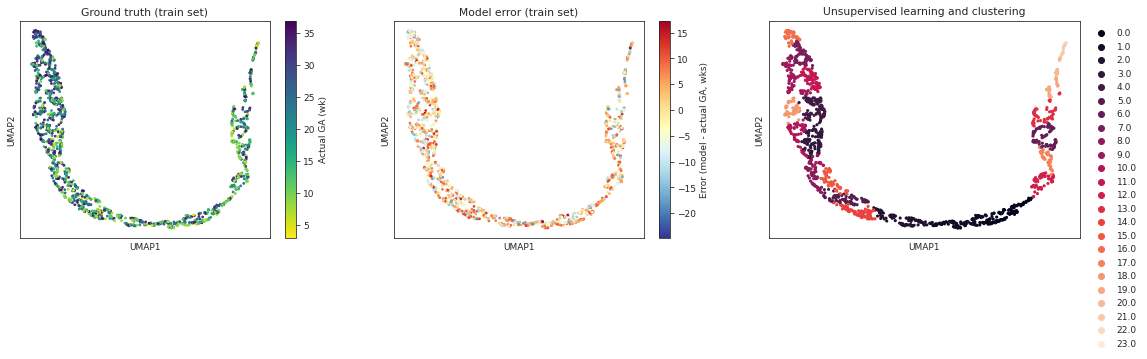

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(19, 4))
# ground truth
im = ax[0].scatter(itrandumap[list(idxs.keys()), 0], 
                   itrandumap[list(idxs.keys()), 1], 
                s=3,
                c=md.loc[list(idxs.values()), 'GA'], 
                   cmap='viridis_r')
fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel('UMAP1')
ax[0].set_ylabel('UMAP2')
ax[0].set_title('Ground truth (train set)')

im = ax[1].scatter(itrandumap[list(idxs.keys()), 0], 
                   itrandumap[list(idxs.keys()), 1],
                s=3,
                c=md.loc[list(idxs.values()), 'error'], cmap='RdYlBu_r')
fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel('UMAP1')
ax[1].set_ylabel('UMAP2')
ax[1].set_title('Model error (train set)')

sns.scatterplot(x=itrandumap[list(idxs.keys()), 0], 
                y=itrandumap[list(idxs.keys()), 1], 
                s=10,
                hue=md.loc[list(idxs.values()), 'rand_leiden'],
                palette='rocket',
                linewidth=0,
#                 palette='ocean', # tab20c
                legend='full', 
                ax=ax[2])
ax[2].legend(bbox_to_anchor=(1.01, 1))
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_xlabel('UMAP1')
ax[2].set_ylabel('UMAP2')
ax[2].set_title('Unsupervised learning and clustering')

if savefigs:
    fig.savefig(os.path.join(pfp, 'eval_umap_ITrand_leiden_v522.pdf'), bbox_inches='tight', dpi=600)

In [75]:
idxs = {i:idx for i, idx in enumerate(itrand.index) if idx in md.loc[md['split']=='train'].index.to_list()}
xy = itrandumap[list(idxs.keys()), :]
dt = md.loc[list(idxs.values())]

# cluster analysis

Place clusters in metadata df and analyze for differences

*data*: 
- `md`: from unsupervised DTW embedding
- `md_model`: from model embeddings
- `md_random`: from random model embeddings (label shuffling)

In [9]:
from wearables.scripts.md_specification import mdpred_voi
from sklearn.metrics.cluster import contingency_matrix

In [204]:
def sigvars_per_cluster(metadata, voi, cluster_key='leiden', bonferonni_crct=True, verbose=True):
    '''Exclusive significance in cluster that is enriched categorically or has log2FC average >=0.5.'''
    def pval2sigvarlist(res, p_cutoff=0.001 / len(voi.keys()) if bonferonni_crct else 0.001, min_l2fc=0.5):
        filtered_res = {k:[] for k in res.keys()}
        for cid in res.keys():
            other_cids = [i for i in res.keys() if i!=cid]
            for var, val in res[cid].items():
                if (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], np.float32) and np.abs(val[1]) >= min_l2fc):
                    filtered_res[cid].append({'var': var,
                                              'type': 'cont',
                                              'name': '{}_l2fc(c-rest)={:.2f}'.format(var, val[1]),
                                              'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'log2fc(c-rest)': val[1]})
                elif (val[0] <= p_cutoff and not any([True if res[k][var][0] <= p_cutoff else False for k in other_cids])) and (isinstance(val[1], pd.DataFrame) and np.unravel_index(np.argmax(val[1].abs()), val[1].shape)[1] == 1):
                    idx = np.unravel_index(np.argmax(val[1].abs()), val[1].shape)
                    filtered_res[cid].append({'var': var,
                                              'type': 'cat',
                                              'name': '{}={} enriched by {:.2f}-%'.format(var, val[1].index[idx[0]], 100*val[1].iloc[idx]),
                                         'P_adj': val[0] / len(voi.keys()) if bonferonni_crct else val[0], 'obs/exp-1': val[1]})
        return filtered_res
    from scipy.stats import chi2_contingency
    from scipy.stats import kruskal
    results = {c:{} for c in np.sort(metadata[cluster_key].unique())}
    # one-vs-rest scheme
    for i, c in enumerate(np.sort(metadata[cluster_key].unique())):
        metadata['cluster_part'] = (metadata[cluster_key] == c)
        for ii, v in enumerate(voi.keys()):
            if voi[v] == 'continuous':
                v_c = metadata.loc[metadata[cluster_key]==c, v]
                v_notc = metadata.loc[metadata[cluster_key]!=c, v]
                statistic, p = kruskal(v_c, v_notc)
                metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC
                metric = np.float32(metric)
            else:
                obs = metadata.groupby([v, 'cluster_part']).size().unstack(fill_value=0)
                chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
                metric = ((obs / expected) - 1) # obs/expected ratio
            results[c][v] = ( p, metric )
    out = pval2sigvarlist(results)
    if verbose:
        for k in np.sort(list(out.keys())):
            for v in out[k]:
                print('cluster_id: {}, annotation: {}'.format(k, v['name'])) 
    return out

In [205]:
def plot_annotations(umap_array, metadata, voi, p1_key='GA', p2_key='error', grp_key='leiden', out_file=None):
    fig, ax = plt.subplots(1, 3, figsize=(19, 4))
    # ground truth
    im = ax[0].scatter(umap_array[:, 0], umap_array[:, 1], 
                    s=3,
                       rasterized=True,
                    c=metadata[p1_key], cmap='viridis_r')
    fig.colorbar(im, label='Actual GA (wk)', ax=ax[0])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_xlabel('UMAP1')
    ax[0].set_ylabel('UMAP2')
    ax[0].set_title('Ground truth (train set)')

    im = ax[1].scatter(umap_array[:, 0], umap_array[:, 1], 
                    s=3, rasterized=True,
                    c=metadata[p2_key], cmap='RdYlBu_r')
    fig.colorbar(im, label='Error (model - actual GA, wks)', ax=ax[1])
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_xlabel('UMAP1')
    ax[1].set_ylabel('UMAP2')
    ax[1].set_title('Model error (train set)')

    # create colorpalette
    cluster_cmap = {c:sns.color_palette('rocket', metadata[grp_key].unique().shape[0])[i] for i, c in enumerate(np.sort(metadata[grp_key].unique()))}

    sns.scatterplot(x=umap_array[:, 0], 
                    y=umap_array[:, 1], 
                    s=10, rasterized=True,
                    hue=metadata[grp_key],
                    palette=cluster_cmap,
                    linewidth=0,
    #                 palette='ocean', # tab20c
                    legend='full', 
                    ax=ax[2])
    ax[2].legend(bbox_to_anchor=(1.01, 1))
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_xlabel('UMAP1')
    ax[2].set_ylabel('UMAP2')
    ax[2].set_title('Unsupervised learning and clustering')

    cluster_analysis = sigvars_per_cluster(metadata, voi, cluster_key=grp_key)

    # add annotations
    texts = []
    for ii, c in enumerate(metadata[grp_key].unique()):
        if cluster_analysis[c] == []:
            continue
        else:
            xyprime = np.mean(umap_array[np.where(metadata[grp_key]==c)[0], :], 0)
            texts.append(ax[2].text(*xyprime, 'Cluster {}: '.format(c)+'; '.join([i['name'] for i in cluster_analysis[c]]), 
                                 fontsize=6,
                                 bbox=dict(fc=cluster_cmap[c],
                                           ec="none", alpha=0.66), weight='bold'))

    adjust_text(texts, ax=ax[2], 
            arrowprops=dict(arrowstyle='->', color='k', alpha=.5))
    
    if out_file is not None:
        fig.savefig(out_file, bbox_inches='tight', dpi=600)
        
    return cluster_analysis


/tmp/ipykernel_800146/2428986945.py:31: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 1, annotation: bc_past1=0.0 enriched by -36.26-%
cluster_id: 2, annotation: paidjob1=0.0 enriched by 38.43-%
cluster_id: 2, annotation: work_hrs1=0.0 enriched by 38.43-%
cluster_id: 2, annotation: stress1_1=0.0 enriched by 88.66-%
cluster_id: 2, annotation: stress7_1=0.0 enriched by 88.66-%
cluster_id: 2, annotation: stress9_1=0.0 enriched by 85.89-%
cluster_id: 2, annotation: workreg_1trim=0.0 enriched by 89.31-%
cluster_id: 2, annotation: choosesleep_1trim=0.0 enriched by 98.63-%
cluster_id: 2, annotation: slpwake_1trim=0.0 enriched by 87.80-%
cluster_id: 2, annotation: slp30_1trim=0.0 enriched by 87.80-%
cluster_id: 2, annotation: sleep_qual1=0.0 enriched by 87.80-%
cluster_id: 2, annotation: sitting1=0.0 enriched by 86.31-%
cluster_id: 2, annotation: tv1=0.0 enriched by 86.31-%
cluster_id: 2, annotation: inactive1=0.0 enriched by 86.31-%
cluster_id: 2, annotation: passenger1=0.0 enriched by 86.31-%
cluster_id: 2, annotation: reset1=0.0 enriched by 86.31-%
cluster_id: 2,

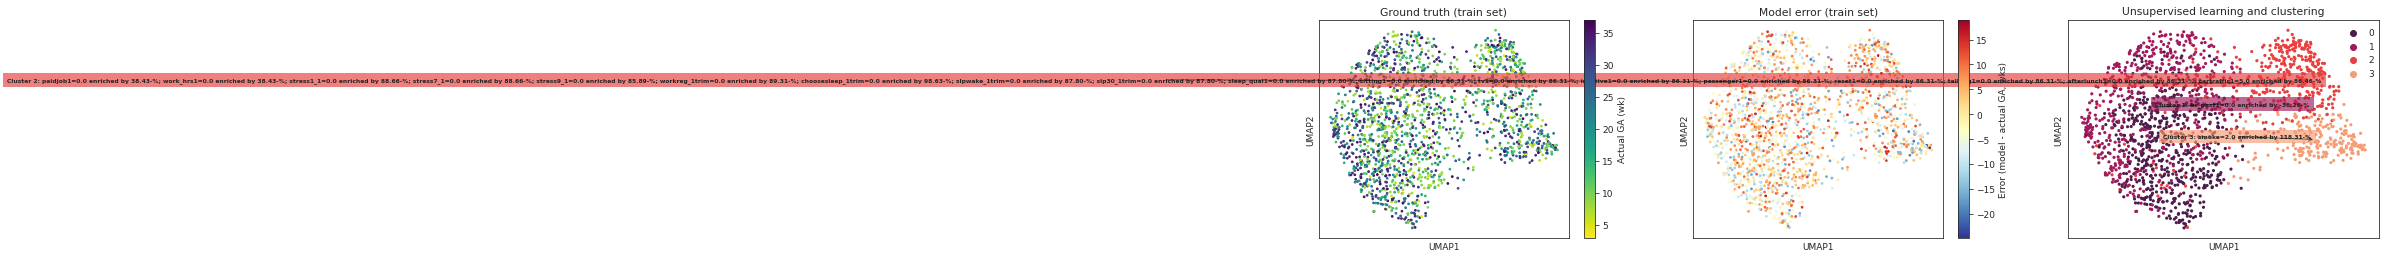

In [206]:
ca_dtw = plot_annotations(dtwumap, mddtw, mdpred_voi, out_file=os.path.join(pfp, 'scatters_umap_dtw_clustannot.pdf'))

/tmp/ipykernel_800146/2428986945.py:31: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 4.0, annotation: premature_birth1=0.0 enriched by 99.57-%
cluster_id: 5.0, annotation: Edinburgh_l2fc(c-rest)=0.71
cluster_id: 7.0, annotation: period_window1=4.0 enriched by -100.00-%
cluster_id: 7.0, annotation: stress2_1=0.0 enriched by 185.42-%
cluster_id: 7.0, annotation: stress9_1=0.0 enriched by 182.03-%
cluster_id: 7.0, annotation: stress10_1=0.0 enriched by 185.42-%
cluster_id: 7.0, annotation: slpwake_1trim=0.0 enriched by 151.54-%
cluster_id: 7.0, annotation: afterlunch1=0.0 enriched by 133.78-%
cluster_id: 7.0, annotation: cartraffic1=3.0 enriched by 141.74-%
cluster_id: 10.0, annotation: gestage_by=0.0 enriched by -100.00-%
cluster_id: 10.0, annotation: paidjob1=0.0 enriched by -86.37-%
cluster_id: 12.0, annotation: other_disease=2.0 enriched by 279.97-%


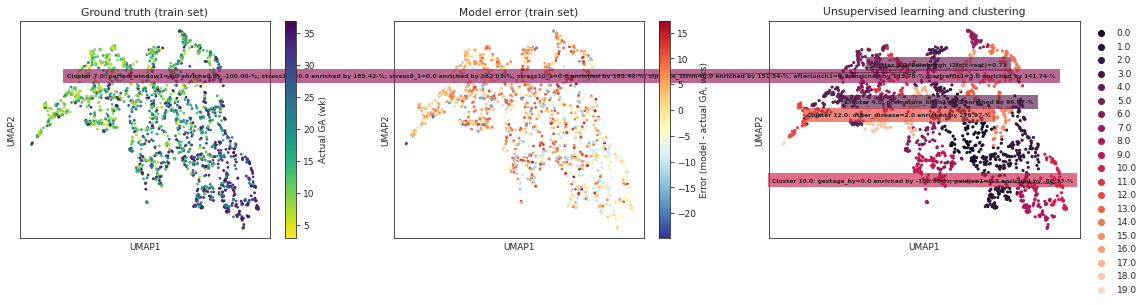

In [207]:
ca_it = plot_annotations(it_umap, it_md, mdpred_voi, out_file=os.path.join(pfp, 'scatters_umap_it_clustannot.pdf'), grp_key='model_leiden')

/tmp/ipykernel_800146/2428986945.py:31: RuntimeWarning: invalid value encountered in log2
  metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC


cluster_id: 11.0, annotation: race=0.0 enriched by 64.70-%
cluster_id: 11.0, annotation: education=1.0 enriched by -100.00-%
cluster_id: 11.0, annotation: paidjob1=0.0 enriched by -80.61-%
cluster_id: 11.0, annotation: work_hrs1=4.0 enriched by 88.06-%
cluster_id: 14.0, annotation: income_annual1=1.0 enriched by 129.40-%
cluster_id: 14.0, annotation: stress2_1=0.0 enriched by 228.34-%
cluster_id: 18.0, annotation: edinb9_1trim=0.0 enriched by 617.67-%
cluster_id: 18.0, annotation: edinb10_1trim=3.0 enriched by 774.66-%


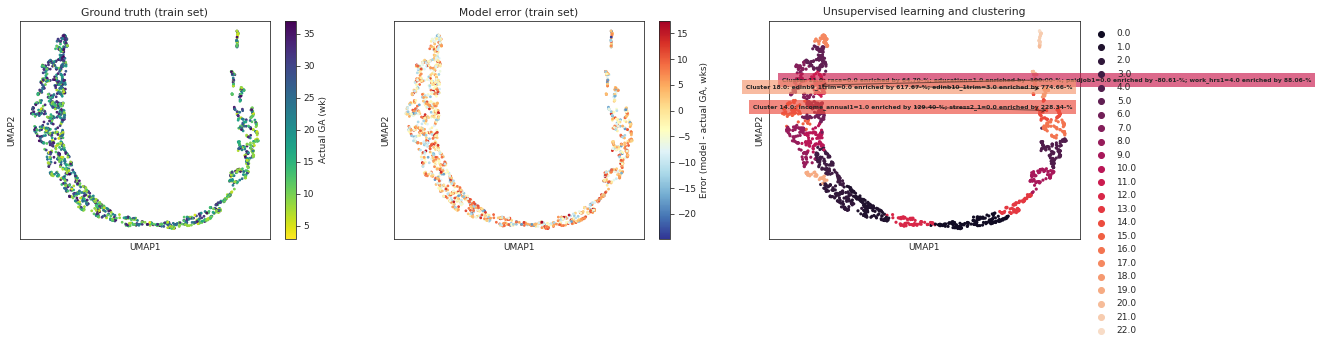

In [209]:
ca_itrand = plot_annotations(itrand_umap, itrand_md, mdpred_voi, out_file=os.path.join(pfp, 'scatters_umap_itrand_clustannot.pdf'), grp_key='rand_leiden')

In [210]:
def p_encoder(p):
    if p > 0.05:
        label = '' # n.s.
    elif p <= 0.001:
        label = '***'
    elif p <= 0.05 and p > 0.01:
        label = '*'
    elif p <= 0.01 and p > 0.001:
        label = '**'
    else: 
        label = 'Unclassified'
    return label


In [215]:
# write out the annotations into a table
def ca_as_series(cluster_analysis):
    dt = pd.DataFrame()
    for i, c in enumerate(cluster_analysis):
        if cluster_analysis[c] == []:
            continue
        else:
            for ii, annotation in enumerate(cluster_analysis[c]): 
                slim = annotation['name'].split(' ')
                a = slim[0]
                a_val = slim[-1]
                p = annotation['P_adj']
                dt = dt.append(pd.DataFrame({'cluster': c, 'var':annotation['var'], 'type': annotation['type'],
                                             'annotation':a, 'enrichment': a_val, 'P_adj':f"{p:.2e}{p_encoder(p)}"}, index=[i+ii]))
                
    return dt


In [105]:
# # save all results
# cluster_annotation = {
#     'itumap': pd.DataFrame(it, index=it.index.to_list()),
#     'itrandumap': pd.DataFrame(itrand, index=itrand.index.to_list()),
#     'dtwumap': pd.DataFrame(dtwumap, index=mddtw.index.to_list()),
#     'md_model_rand': md,
#     'md_dtw': mddtw,
#     'dtw_cluster_annotation': dtw_clustanal,
#     'model_cluster_annotation': model_clustanal,
#     'rand_cluster_annotation': rand_clustanal,
# }
# with open(os.path.join(pfp, 'model_embeds_clustannotation.pkl'), 'wb') as f:
#     pickle.dump(cluster_annotation, f, protocol=pickle.HIGHEST_PROTOCOL)
#     f.close()


## validation of annotation

Does the annotation hold in the test set

**NOTE**: map test set to train set clusters, then see if the population trend is there

In [155]:
# get the train splits
idxs = {i:idx for i, idx in enumerate(it.index) if idx in md.loc[md['split']=='test'].index.to_list()}
itumap_tst = itumap[list(idxs.keys()), :]
itmd_tst = md.loc[list(idxs.values()), :]

idxs = {i:idx for i, idx in enumerate(itrand.index) if idx in md.loc[md['split']=='test'].index.to_list()}
itrandumap_tst = itrandumap[list(idxs.keys()), :]
itrandmd_tst = md.loc[list(idxs.values()), :]

In [276]:
def grp_stat(df, var, var_type, grp_key, grp):
    '''
    Arguments:
      var_type (str): cont or cat
    '''
    if 'cont' in var_type:
        v_c = df.loc[df[grp_key]==grp, var]
        v_notc = df.loc[df[grp_key]!=grp, var]
        statistic, p = kruskal(v_c, v_notc)
        metric = np.log2(np.nanmean(v_c)) - np.log2(np.nanmean(v_notc)) # log2FC
        metric = np.float32(metric)
    else:
        df['cluster_part'] = (df[grp_key] == grp)
        obs = df.groupby([var, 'cluster_part']).size().unstack(fill_value=0)
        chi2, p, dof, expected = chi2_contingency(obs) # Fischer's?
        metric = ((obs / expected) - 1) # obs/expected ratio
    return p, metric

In [320]:
def validate_annotation(cluster_analysis, d1, d2, md1, md2, grp_key='leiden', p_threshold=0.05):
    '''
    Arguments:
      d1 : train
      d2 : test
      md1 : train metadata
      md2 : test metadata
    '''
    for i, c in enumerate(np.sort(md1[grp_key].unique())):
        if i==0:
            x = d1[np.where(md1[grp_key]==c)[0]].mean(0)
        else:
            x = np.vstack((x, d1[np.where(md1[grp_key]==c)[0]].mean(0)))
    md2['mapped_clusterid'] = np.apply_along_axis(lambda x_i: np.sqrt(np.sum((x - x_i)**2, 1)).argmin(), 1, d2)
    res = ca_as_series(cluster_analysis)
    res = res.reset_index()
    for idx in res.index:
        p, metric = grp_stat(md2, res.loc[idx, 'var'],
                             res.loc[idx, 'type'], grp_key,#'mapped_clusterid', 
                             res.loc[idx, 'cluster'])
        res.loc[idx, 'P_adj_tst'] = f"{p:.2e}{p_encoder(p)}"
        res.loc[idx, 'metric_tst'] = f"{metric:}"
        res.loc[idx, 'validated'] = 'Y' if p <= p_threshold else 'N'
    del res['index']
    return res

In [316]:
mddtw_train = mddtw.sample(int(0.8*mddtw.shape[0]), replace=False)
idx_train = [np.where(mddtw.index==i)[0].item() for i in mddtw_train.index]
dtwumap_train = dtwumap[idx_train, :]
mddtw_tst = mddtw.loc[mddtw.index[~mddtw.index.isin(mddtw_train.index)], :]
idx_tst = [np.where(mddtw_tst.index==i)[0].item() for i in mddtw_tst.index]
dtwumap_tst = dtwumap[idx_tst, :]


In [317]:
res_dtw = validate_annotation(ca_dtw, dtwumap_train, dtwumap_tst, mddtw_train, mddtw_tst, grp_key='leiden')
res_dtw

,cluster,var,type,annotation,enrichment,P_adj,P_adj_tst,metric_tst,validated
0,1,bc_past1,cat,bc_past1=0.0,-36.26-%,1.68e-08***,4.88e-01,cluster_part False True\nbc_past1 ...,N
1,2,paidjob1,cat,paidjob1=0.0,38.43-%,3.79e-10***,9.86e-01,cluster_part False True\npaidjob1 ...,N
2,2,work_hrs1,cat,work_hrs1=0.0,38.43-%,6.04e-10***,9.09e-01,cluster_part False True\nwork_hrs1 ...,N
3,2,stress1_1,cat,stress1_1=0.0,88.66-%,1.42e-10***,6.06e-01,cluster_part False True\nstress1_1 ...,N
4,2,stress7_1,cat,stress7_1=0.0,88.66-%,3.29e-08***,9.16e-01,cluster_part False True\nstress7_1 ...,N
5,2,stress9_1,cat,stress9_1=0.0,85.89-%,3.81e-11***,8.81e-01,cluster_part False True\nstress9_1 ...,N
6,2,workreg_1trim,cat,workreg_1trim=0.0,89.31-%,2.34e-10***,8.02e-01,cluster_part False True\nworkreg_1tr...,N
7,2,choosesleep_1trim,cat,choosesleep_1trim=0.0,98.63-%,6.23e-11***,6.71e-01,cluster_part False True\nchooses...,N
8,2,slpwake_1trim,cat,slpwake_1trim=0.0,87.80-%,2.55e-09***,7.71e-01,cluster_part False True\nslpwake_1tr...,N
9,2,slp30_1trim,cat,slp30_1trim=0.0,87.80-%,4.62e-09***,4.78e-01,cluster_part False True\nslp30_1trim ...,N


In [321]:
res_it = validate_annotation(ca_dtw, it_umap, itumap_tst, it_md, itmd_tst, grp_key='model_leiden')
res_it

,cluster,var,type,annotation,enrichment,P_adj,P_adj_tst,metric_tst,validated
0,1,bc_past1,cat,bc_past1=0.0,-36.26-%,1.68e-08***,2.49e-01,cluster_part False True\nbc_past1 ...,N
1,2,paidjob1,cat,paidjob1=0.0,38.43-%,3.79e-10***,4.02e-01,cluster_part False True\npaidjob1 ...,N
2,2,work_hrs1,cat,work_hrs1=0.0,38.43-%,6.04e-10***,5.86e-01,cluster_part False True\nwork_hrs1 ...,N
3,2,stress1_1,cat,stress1_1=0.0,88.66-%,1.42e-10***,7.24e-01,cluster_part False True\nstress1_1 ...,N
4,2,stress7_1,cat,stress7_1=0.0,88.66-%,3.29e-08***,4.51e-01,cluster_part False True\nstress7_1 ...,N
5,2,stress9_1,cat,stress9_1=0.0,85.89-%,3.81e-11***,5.27e-01,cluster_part False True\nstress9_1 ...,N
6,2,workreg_1trim,cat,workreg_1trim=0.0,89.31-%,2.34e-10***,9.51e-02,cluster_part False True\nworkreg_1tr...,N
7,2,choosesleep_1trim,cat,choosesleep_1trim=0.0,98.63-%,6.23e-11***,1.02e-01,cluster_part False True\nchooses...,N
8,2,slpwake_1trim,cat,slpwake_1trim=0.0,87.80-%,2.55e-09***,4.73e-01,cluster_part False True\nslpwake_1tr...,N
9,2,slp30_1trim,cat,slp30_1trim=0.0,87.80-%,4.62e-09***,1.38e-01,cluster_part False True\nslp30_1trim ...,N


In [319]:
res_itrand = validate_annotation(ca_dtw, itrand_umap, itrandumap_tst, itrand_md, itrandmd_tst, grp_key='rand_leiden')
res_itrand

,cluster,var,type,annotation,enrichment,P_adj,P_adj_tst,metric_tst,validated
0,1,bc_past1,cat,bc_past1=0.0,-36.26-%,1.68e-08***,7.25e-01,cluster_part False True\nbc_past1 ...,N
1,2,paidjob1,cat,paidjob1=0.0,38.43-%,3.79e-10***,7.27e-01,cluster_part False True\npaidjob1 ...,N
2,2,work_hrs1,cat,work_hrs1=0.0,38.43-%,6.04e-10***,6.09e-01,cluster_part False True\nwork_hrs1 ...,N
3,2,stress1_1,cat,stress1_1=0.0,88.66-%,1.42e-10***,5.39e-01,cluster_part False True\nstress1_1 ...,N
4,2,stress7_1,cat,stress7_1=0.0,88.66-%,3.29e-08***,2.48e-01,cluster_part False True\nstress7_1 ...,N
5,2,stress9_1,cat,stress9_1=0.0,85.89-%,3.81e-11***,5.52e-01,cluster_part False True\nstress9_1 ...,N
6,2,workreg_1trim,cat,workreg_1trim=0.0,89.31-%,2.34e-10***,6.49e-01,cluster_part False True\nworkreg_1tr...,N
7,2,choosesleep_1trim,cat,choosesleep_1trim=0.0,98.63-%,6.23e-11***,1.94e-01,cluster_part False True\nchooses...,N
8,2,slpwake_1trim,cat,slpwake_1trim=0.0,87.80-%,2.55e-09***,4.84e-01,cluster_part False True\nslpwake_1tr...,N
9,2,slp30_1trim,cat,slp30_1trim=0.0,87.80-%,4.62e-09***,8.96e-01,cluster_part False True\nslp30_1trim ...,N


# predictability of model embeddings

Show that they're more useful than kNN/TSRF/LightGBM on actigraphy

## GA and all others

### data

In [3]:
# add back GA to pred
from wearables.scripts.md_specification import mdpred_voi
import wearables.scripts.eval_ as weareval
pfp = '/home/ngrav/project/wearables/results/'
mfp = '/home/ngrav/project/wearables/model_zoo'

# filepaths to bst or pre-processed md with calculated metrics 
pp_md_fp = os.path.join(pfp, 'md_v522_220124.csv')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_modelembeds = os.path.join(pfp, 'embeds_v522_220124.csv')

# load up to date md
md = pd.read_csv(pp_md_fp, index_col=0)
def loadpkl(fp):
    with open(fp, 'rb') as f:
        return pickle.load(f)
trainer = loadpkl(bst_trainer)
it = pd.read_csv(bst_modelembeds, index_col=0)

# update mdpred_voi to include GA prediction
mdpred_voi['GA'] = 'continuous'


In [69]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import sklearn.metrics as sklmetrics
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
from wearables.scripts import eval_ as weareval
from imblearn.over_sampling import SMOTE

In [125]:
class knncv():
    def __init__(self, metadata, voi, embeds=None, trainer=None):
        '''Association by effectiveness of the classifier or coefficients.

        Arguments:
          voi (dict)
          embeds (pd.DataFrame): it
          trainer (obj): 
          metadata (pd.DataFrame): contains labels. Assumes index is unique_id to match with list of ids from embeddings
        '''
        self.metadata = metadata
        self.voi = voi
        self.embeds = embeds
        self.trainer = trainer
        # self.X = self.get_model_X()
        self.get_model_X()
        self.res = {} # 'class_nb': (model, scores)
        self.summary = {}
            
    def get_model_X(self):
        # load data
        if self.embeds is not None:
            self.data = self.embeds
            self.grps = [s.split('_')[0] for s in self.data.index]
        elif self.trainer is not None:
            # error prone, custom implementation
            self.data = pd.DataFrame({uid: trainer.data.data['data'][uid]['activity'][:-1].to_numpy() for uid in trainer.data.data['IDs']}).T
            self.grps = [s.split('_')[0] for s in data.index]
        self.splitter = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=42)
        # return self.data.to_numpy(dtype=np.float32)
        
    def get_model_y(self, target_name):
        y = self.metadata.loc[self.data.index.to_list(), target_name]
        if 'cat' in self.voi[target_name]: 
            # convert to int
            if len(y.unique()) == 1:
                print(f"\nonly one val for {target_name}")
                print('... cannot fit one class only. Reconsider its inclusion. Skipping this var.')
                return None

            else:
                try:
                    y = y.to_numpy(dtype=int)
                    if len(np.unique(y)) > 2:
                        y = label_binarize(y, classes=np.sort(np.unique(y)))
                    else:
                        y = y.reshape(-1, 1)
                except ValueError:
                    y = label_binarize(y, classes=np.sort(np.unique(y)))
        else:
            y = y.to_numpy(dtype=np.float32)
        return y
    
    def fit(self, target_name, smote=True, verbose=False):
        X, y = self.data.to_numpy(dtype=np.float32), self.get_model_y(target_name)
        # CV splits
        for i, (train_idx, test_idx) in enumerate(self.splitter.split(X, y, self.grps)):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]

            if 'cat' in self.voi[target_name]: # SMOTE
                fpr, tpr = dict(), dict()
                au_roc, eval_metrics = dict(), dict()
                for jj in range(y_train.shape[1]):
                    if smote:
                        oversample = SMOTE(k_neighbors=3)
                        # print(f'kk: {kk}\tX_train: {X_train.shape}\ty_train: {y_train.shape}')
                        try:
                            X_train_mod, y_train_mod = oversample.fit_resample(X_train, y_train[:, jj])
                        except ValueError:
                            print("\n{}-th class cannot be computed. Too few n_samples. Skipping".format(jj)) 
                            if verbose:
                                print('{} class frequencies:'.format(catvar))
                                for jjj in range(y_train.shape[1]):
                                    print(f"j: {jjj}\t0: {(y_train[:, jjj]==0).sum()}\t1: {(y_train[:, jjj]==1).sum()}")
                            continue
                        del oversample
                    else:
                        X_train_mod, y_train_mod = X_train, y_train

                    # model/eval
                    model = KNeighborsClassifier(n_jobs=12)
                    model.fit(X_train_mod, y_train_mod)
                    (fpr[jj], tpr[jj], thresholds) = sklmetrics.roc_curve(y_test[:, jj], model.predict_proba(X_test)[:, 1])
                    au_roc[jj] = sklmetrics.auc(fpr[jj], tpr[jj])
                    eval_metrics[jj] = weareval.eval_output(model.predict(X_test), y_test[:, jj], 
                                                            tasktype='regression' if 'cont' in self.voi[target_name] else 'classification')
                    # scores = cross_val_score(lr, X_train_mod, y_train_mod, cv=5, scoring='roc_curve')
                self.res[f'{target_name}_fold{i}'] = (fpr, tpr, au_roc, eval_metrics) # (lr, scores)
            else:
                model = KNeighborsRegressor(n_jobs=12) 
                model.fit(X_train, y_train)
                self.res[f'{target_name}_fold{i}'] = weareval.eval_output(model.predict(X_test), y_test, 
                                                                          tasktype='regression' if 'cont' in self.voi[target_name] else 'classification')
    
    def fit_all(self, verbose=True):
        if verbose:
            tic_total = time.time()
        for i, (target_name, task_type) in enumerate(self.voi.items()):
            if verbose:
                tic = time.time()
                print('Starting {} ({} of n={} tasks)...'.format(target_name, i+1, len(self.voi.keys())))
            self.fit(target_name)
            if verbose:
                print('... done in {:.2f}-s\t{:.1f}-min elapsed'.format(time.time() - tic, (time.time() - tic_total)/60))
        # generate summary
        self.summarize()
                
    def summarize(self, reg_metric='rho', clf_metric='auroc'):
        '''
        Arguments:
          reg_metric (str): [optional] one of 'rho', 'mae', 'mape'
          clf_metric (str): [optional] one of 'auroc', 'auprc'
        '''
        for i, k in enumerate(self.voi.keys()):
            all_folds = [ii for ii in self.res.keys() if ii.split('_fold')[0]==k]
            if 'cont' in self.voi[k]:
                metric = []
                for kk in all_folds:
                    metric.append(self.res[kk][reg_metric])
            else:
                if clf_metric == 'auroc':
                # macro-average
                    metric = []
                    for kk in all_folds:
                        within_class = []
                        for k_class in self.res[kk][2].keys():
                            within_class.append(self.res[kk][2][k_class])
                        metric.append(np.nanmean(within_class)) # could max?
                elif clf_metric == 'auprc':
                    for kk in all_folds:
                        within_class = []
                        for k_class in self.res[kk][3].keys():
                            within_class.append(self.res[kk][3]['auprc_model'])
                        metric.append(np.nanmean(within_class)) 
                elif clf_metric == 'prc':
                    counter = 0
                    for kk in all_folds:
                        for j, k_class in self.res[kk][0].keys():
                            if counter==0:
                                all_fpr = self.res[kk][0][k_class]
                                counter += 1
                            else:
                                all_fpr = np.concatenate((all_fpr, self.res[kk][0][k_class]))
                                counter += 1
                    all_fpr = np.unique(all_fpr)
                    metric = []
                    counter = 0
                    for kk in all_folds: 
                        for j, n_class in enumerate(range(len(self.res[kk][0].keys()))):
                            if counter == 0:
                                tpr = np.interp(all_fpr, self.res[kk][0][n_class], self.res[kk][1][n_class])
                            else:
                                tpr = np.vstack((tpr, np.interp(all_fpr, self.res[kk][0][n_class], self.res[kk][1][n_class])))
                    metric.append((all_fpr, tpr))
            self.summary[k] = metric

In [126]:
tst = {'age_enroll': 'continuous',
 'marital': 'categorical',
 'bmi_1vis': 'continuous',}

In [127]:
knns = knncv(md, tst, trainer=trainer)

### simple comparisons plot
#### detail of ptb or one interesting

In [206]:
savefigs = True

In [207]:
res = loadpkl('/home/ngrav/project/wearables/results/comp_modelembedsVrawactigraphy_kNN_220321.pkl')


In [208]:
from wearables.scripts.aesthetics import md_node_annotation, md_node_category_cmap
md_node_annotation['GA'] = 'Pregnancy outcome'

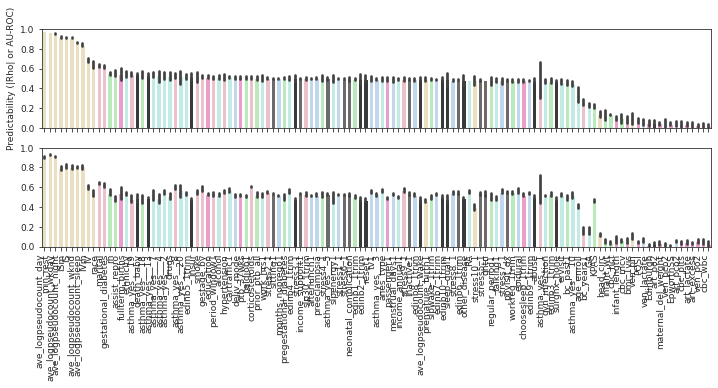

In [209]:
fig, ax = plt.subplots(2, 1, figsize=(12, 4))

# raw
dt = pd.DataFrame(res['knn_raw'][0]).T.reset_index().melt(id_vars=['index'])
dt['value'] = dt['value'].abs() # abs corr
dt['annotation'] = dt['index'].map(md_node_annotation)
order = dt.groupby('index').mean().sort_values(by='value', ascending=False).index.to_list()
sns.barplot(x='index', y='value', data=dt,
            order=order, 
            hue='annotation', 
            dodge=False,
            palette=md_node_category_cmap,
            ax=ax[0])
#embeddings
dt = pd.DataFrame(res['knn_embeds'][0]).T.reset_index().melt(id_vars=['index'])
dt['value'] = dt['value'].abs() # abs corr
dt['annotation'] = dt['index'].map(md_node_annotation)
sns.barplot(x='index', y='value', data=dt,
            order=order, 
            hue='annotation', 
            dodge=False,
            palette=md_node_category_cmap,
            ax=ax[1])

ax[0].set_ylim([0, 1])
ax[1].set_ylim([0, 1])
ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].legend().set_visible(False)
ax[0].set_ylabel('Predictability (|Rho| or AU-ROC)')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend().set_visible(False)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_predictabilityVmdvar.pdf'), bbox_inches='tight')

In [210]:
dt1 = pd.DataFrame(res['knn_raw'][0]).T.reset_index().melt(id_vars=['index'])
dt1['value'] = dt1['value'].abs() # abs corr
dt1['annotation'] = dt1['index'].map(md_node_annotation)

dt2 = pd.DataFrame(res['knn_embeds'][0]).T.reset_index().melt(id_vars=['index'])
dt2['value'] = dt2['value'].abs() # abs corr
dt2['annotation'] = dt2['index'].map(md_node_annotation)

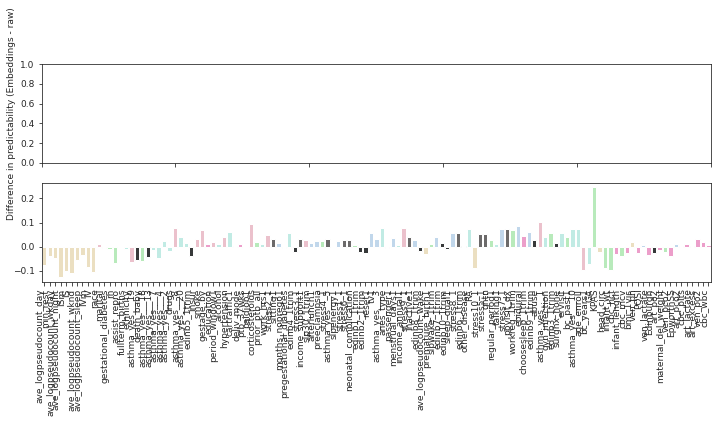

In [211]:
dt3 = dt2.groupby('index').mean() - dt1.groupby('index').mean()
dt3 = dt3.reset_index()
dt3['annotation'] = dt3['index'].map(md_node_annotation)

fig, ax = plt.subplots(2, 1, figsize=(12, 4))

sns.barplot(x='index', y='value', data=dt3,
            order=order, 
            hue='annotation', 
            dodge=False,
            palette=md_node_category_cmap,
            ax=ax[1])

ax[0].set_xticklabels('')
ax[0].set_xlabel('')
ax[0].set_ylabel('Difference in predictability (Embeddings - raw)')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].legend().set_visible(False)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='right')

if savefigs:
    fig.savefig(os.path.join(pfp, 'barplot_diffpredict_embed-raw.pdf'), bbox_inches='tight')

,index,variable,value,annotation,type
0,age_enroll,0,0.258429,Social determinants of health,Raw
1,marital,0,0.635760,Social determinants of health,Raw
2,gestage_by,0,0.535635,Procedural,Raw
3,insur,0,0.560691,Social determinants of health,Raw
4,ethnicity,0,0.551425,Social determinants of health,Raw
...,...,...,...,...,...
610,PQSI,4,0.062036,Sleep-quality,Raw
611,KPAS,4,0.124365,Activity-related,Raw
612,EpworthSS,4,0.035627,Sleep-quality,Raw
613,Edinburgh,4,0.063234,Depression-related,Raw


In [212]:
# stat test
dt2['value'].mean()

0.4594136402216019

In [213]:
dt1['value'].mean()

0.4519488610106185

In [214]:
dt2['value'].mean() - dt1['value'].mean()

0.00746477921098343

In [215]:
from scipy.stats import mannwhitneyu
mannwhitneyu(dt1['value'], dt2['value'])

MannwhitneyuResult(statistic=160880.0, pvalue=2.9158793859882507e-06)

In [216]:
dt1['type'] = 'Raw'
dt2['type'] = 'Embeddings'

In [217]:
dt = dt1.append(dt2)

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 75.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


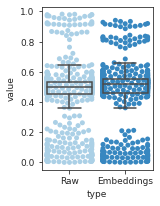

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(2, 3))
sns.swarmplot(x='type', y='value', data=dt, ax=ax, palette='Blues', zorder=0)
sns.boxplot(x='type', y='value', data=dt, ax=ax, palette='Blues', zorder=1, boxprops={'facecolor': 'none'}, showfliers=False)

if savefigs:
    fig.savefig(os.path.join(pfp, 'swarmplot_predictVtypedata.pdf'), bbox_inches='tight')

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


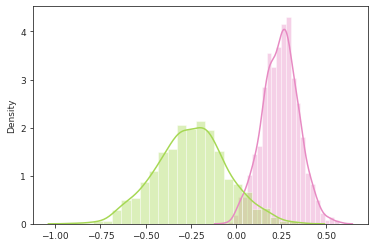

In [232]:
# schematic figure
fig, ax = plt.subplots(1, 1)
sns.distplot(np.random.normal(0.25, 0.1, size=(1000,)), color=sns.color_palette('Set2')[3], ax=ax)
sns.distplot(np.random.normal(-0.25, 0.2, size=(1000,)), color=sns.color_palette('Set2')[4], ax=ax)
fig.savefig(os.path.join(pfp, 'distplot_example.pdf'))

In [237]:
list(np.array([183, 36, 103])/256)

[0.71484375, 0.140625, 0.40234375]

/home/ngrav/miniconda3/envs/wearables/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


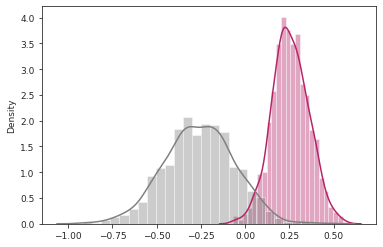

In [238]:
# schematic figure
fig, ax = plt.subplots(1, 1)
sns.distplot(np.random.normal(0.25, 0.1, size=(1000,)), color=list(np.array([183, 36, 103])/256), ax=ax)
sns.distplot(np.random.normal(-0.25, 0.2, size=(1000,)), color='gray', ax=ax)
fig.savefig(os.path.join(pfp, 'distplot_example2.pdf'))